In [1]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import dags.scripts.preprocess as pr
import dags.scripts.set_matplotlib_hangul as set_matplotlib_hangul


Hangul OK in your Windows!!!


In [2]:
# 데이터 불러오기러오기
def load_csv():
    orders = pd.read_csv('./dags/data/orders.csv')
    aisles = pd.read_csv('./dags/data/aisles.csv')
    departments = pd.read_csv('./dags/data/departments.csv')
    order_products_prior = pd.read_csv('./dags/data/order_products__prior.csv')
    order_products_train = pd.read_csv('./dags/data/order_products__train.csv')
    products = pd.read_csv('./dags/data/products.csv')

    return orders, aisles, departments, order_products_prior, order_products_train, products

In [3]:
# 함수 호출
orders, aisles, departments, order_products_prior, order_products_train, products = load_csv()

In [4]:
# 데이터 전처리리
def clean_orders(orders):
    orders['days_since_prior_order'].fillna(0, inplace=True)
    return orders

In [5]:
# 함수 호출
orders = clean_orders(orders)
orders.isnull().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

In [6]:
# 데이터 훈련데이터와 정답데이터 분리
def split_orders(orders):
    orders_prior = orders[orders['eval_set'] == 'prior'].drop(columns=['eval_set'])
    orders_train = orders[orders['eval_set'] == 'train'].drop(columns=['eval_set'])
    return orders_prior, orders_train


In [7]:
# 함수 호출
orders_prior, orders_train = split_orders(orders)

In [8]:
# 불필요한 컬럼 삭제제
def clean_order_products(df):
    if 'add_to_cart_order' in df.columns:
        return df.drop(columns=['add_to_cart_order'])
    return df

In [9]:
# 함수 호출
order_products_prior = clean_order_products(order_products_prior)
order_products_train = clean_order_products(order_products_train)


In [10]:
# 데이터 합치기
def merge_dataframes(orders_prior, order_products_prior, products, departments, aisles):
    df_total = orders_prior.merge(order_products_prior, on='order_id', how='left')
    df_total = df_total.merge(products, on='product_id', how='inner')
    df_total = df_total.merge(departments, on='department_id', how='inner')
    df_total = df_total.merge(aisles, on='aisle_id', how='inner')
    return df_total

In [11]:
# 함수 호출
df_total = merge_dataframes(orders_prior, order_products_prior, products, departments, aisles)

In [12]:
df_total = df_total.sample(n=10000000, random_state=42)
df_total.to_csv('./dags/data/total.csv')


In [13]:
df_total

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,product_name,aisle_id,department_id,department,aisle
29481110,1929421,121204,4,3,15,30.0,17985,0,Uncooked Medium Flour Tortillas,128,3,bakery,tortillas flat bread
2852353,1411974,36310,38,2,16,6.0,24838,0,Unsweetened Almondmilk,91,16,dairy eggs,soy lactosefree
11194500,279914,122682,42,4,16,2.0,39280,0,White Big Roll,54,17,household,paper goods
15909397,3198911,182025,21,6,13,7.0,43961,1,Organic Peeled Whole Baby Carrots,123,4,produce,packaged vegetables fruits
6101870,2147415,127943,7,6,9,22.0,42828,1,Whipped Cream Cheese,108,16,dairy eggs,other creams cheeses
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15959716,1528680,187679,5,1,9,7.0,11777,1,Red Raspberries,123,4,produce,packaged vegetables fruits
14978746,2648194,16274,61,0,14,9.0,47630,0,Medium Navel Orange,24,4,produce,fresh fruits
10908104,33168,134598,22,2,11,14.0,44595,0,Golden Oreo Thins,61,19,snacks,cookies cakes
2350014,1546433,99694,6,2,19,6.0,1096,1,9.5 pH Super Hydrating Purified Water,115,7,beverages,water seltzer sparkling water


In [15]:
# 사용자별 평균 재구매율(user_reorder_rate) 계산
user_reorder_rate = df_total.groupby('user_id')['reordered'].mean().reset_index()
user_reorder_rate.columns = ['user_id', 'user_reorder_rate']

# df_total에 merge
df_total = df_total.merge(user_reorder_rate, on='user_id', how='left')

In [16]:
# 상품별 평균 재구매율율
product_reorder_rate = df_total.groupby('product_id')['reordered'].mean().reset_index()
product_reorder_rate.columns = ['product_id', 'product_reorder_rate']

# df_total에 merge
df_total = df_total.merge(product_reorder_rate, on='product_id', how='left')


In [17]:
# 사용자가 해당 상품을 몇번 구매 했는지 지표표
user_product_reorder = df_total.groupby(['user_id', 'product_id'])['reordered'].sum().reset_index()
user_product_reorder.columns = ['user_id', 'product_id', 'user_product_reorder_count']

# df_total에 merge
df_total = df_total.merge(user_product_reorder, on=['user_id', 'product_id'], how='left')


In [18]:
# 1. 유저-상품 기준으로 정렬
df_total = df_total.sort_values(['user_id', 'product_id', 'order_number'])

# 2. 과거 주문 시점과의 간격 계산하여 주기 확인인
df_total['days_since_product_last_order'] = df_total.groupby(['user_id', 'product_id'])['days_since_prior_order'].shift(1)

# 3. 결측치는 0 또는 -1 등으로 채워줌
df_total['days_since_product_last_order'] = df_total['days_since_product_last_order'].fillna(0)

In [19]:
# 사용자 별 총 주문 횟수수
user_order_count = df_total.groupby('user_id')['order_number'].max().reset_index()
user_order_count.columns = ['user_id', 'user_total_orders']
df_total = df_total.merge(user_order_count, on='user_id', how='left')


In [20]:
# 1. 사용자 상품별 총 주문 횟수
user_product_orders = df_total.groupby(['user_id', 'product_id'])['reordered'].count().reset_index()
user_total_orders = df_total.groupby('user_id')['order_number'].max().reset_index()

# 2. 사용자별 전체 주문 횟수 계산
user_product_orders.columns = ['user_id', 'product_id', 'user_product_orders']
user_total_orders.columns = ['user_id', 'user_total_orders']

# 3. 두 테이블을 merge해서 비율 계산
df_ratio = user_product_orders.merge(user_total_orders, on='user_id')
df_ratio['user_product_order_ratio'] = df_ratio['user_product_orders'] / df_ratio['user_total_orders']

# 4. 최종적으로 df_total에 합침침
df_total = df_total.merge(df_ratio[['user_id', 'product_id', 'user_product_order_ratio']],
                          on=['user_id', 'product_id'], how='left')


In [21]:
# ✅ 상품명 기준 주문량 상위 10개 추출
top10 = (
    df_total['product_name']
    .value_counts()
    .head(10)
    .reset_index()
)

# ✅ 컬럼명 명확히 설정
top10.columns = ['상품명', '주문량']  # <- 여기서 명확하게 설정!

# ✅ 상품명으로 중분류/대분류 정보 추출
product_info = df_total[['product_name', 'aisle', 'department']].drop_duplicates()

# ✅ merge 진행
top10_merged = top10.merge(product_info, left_on='상품명', right_on='product_name', how='left')

# ✅ 최종 테이블 정리
top10_final = top10_merged[['상품명', 'department', '주문량']]
top10_final.columns = ['상품명', '대분류', '주문량']
top10_final.insert(0, '순위', range(1, 11))

# ✅ 확인
top10_final


,순위,상품명,대분류,주문량
0,1,Banana,produce,291205
1,2,Bag of Organic Bananas,produce,233771
2,3,Organic Strawberries,produce,163422
3,4,Organic Baby Spinach,produce,148888
4,5,Organic Hass Avocado,produce,132052
5,6,Organic Avocado,produce,108728
6,7,Large Lemon,produce,94066
7,8,Strawberries,produce,88192
8,9,Limes,produce,86932
9,10,Organic Whole Milk,dairy eggs,85006


In [22]:
# ✅ 상품명 기준 주문량 상위 10개 추출
top10 = (
    df_total['product_name']
    .value_counts()
    .head(10)
    .reset_index()
)

# ✅ 컬럼명 명확히 설정
top10.columns = ['상품명', '주문량']

# ✅ 상품명으로 중분류/대분류 정보 추출
product_info = df_total[['product_name', 'aisle', 'department']].drop_duplicates()

# ✅ merge 진행
top10_merged = top10.merge(product_info, left_on='상품명', right_on='product_name', how='left')

# ✅ 최종 테이블 정리
top10_final = top10_merged[['상품명', 'department', '주문량']]
top10_final.columns = ['상품명', '대분류', '주문량']
top10_final.insert(0, '순위', range(1, 11))

# ✅ 전체 주문량 기준 비율 추가
total_orders = df_total.shape[0]  # 또는 df_total['order_id'].count() 도 가능
top10_final['비율(%)'] = (top10_final['주문량'] / total_orders * 100).round(2)

# ✅ 확인
top10_final


,순위,상품명,대분류,주문량,비율(%)
0,1,Banana,produce,291205,1.46
1,2,Bag of Organic Bananas,produce,233771,1.17
2,3,Organic Strawberries,produce,163422,0.82
3,4,Organic Baby Spinach,produce,148888,0.74
4,5,Organic Hass Avocado,produce,132052,0.66
5,6,Organic Avocado,produce,108728,0.54
6,7,Large Lemon,produce,94066,0.47
7,8,Strawberries,produce,88192,0.44
8,9,Limes,produce,86932,0.43
9,10,Organic Whole Milk,dairy eggs,85006,0.43


In [23]:
## EDA

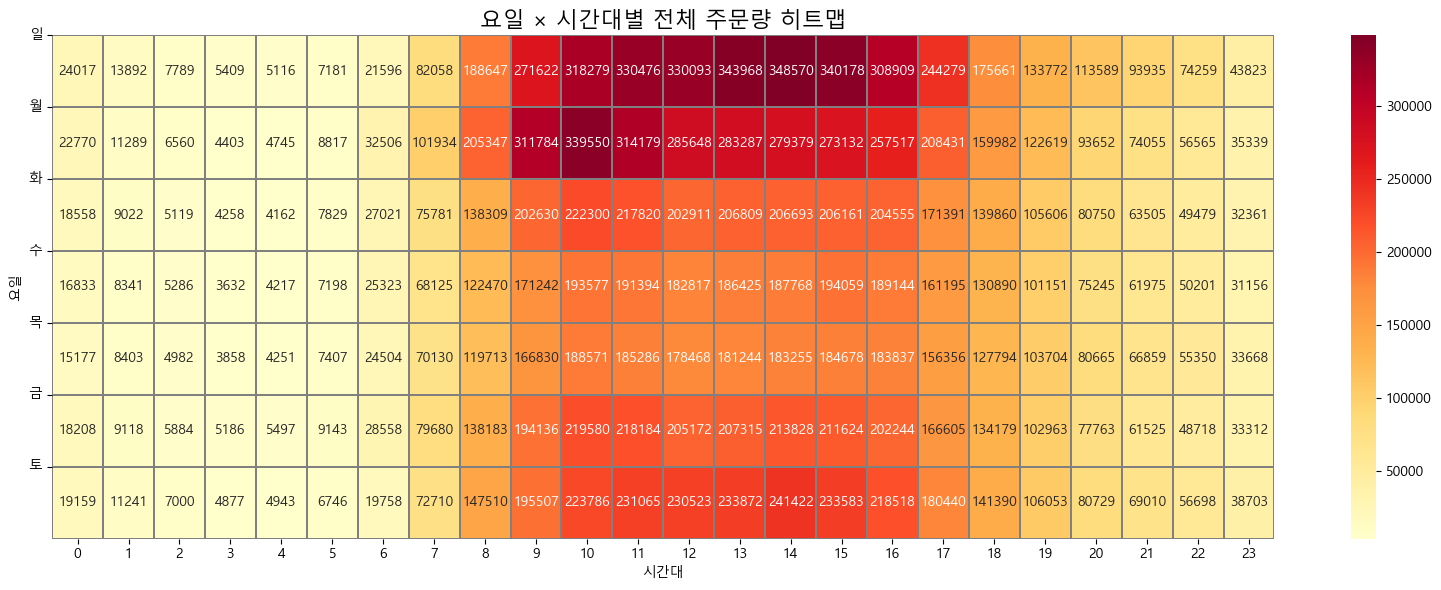

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 요일 × 시간대별 주문량 집계
df_heatmap = df_total.groupby(['order_dow', 'order_hour_of_day']) \
                     .size().reset_index(name='order_count')

# 2. 피벗 테이블 만들기
pivot_heatmap = df_heatmap.pivot(index='order_dow', columns='order_hour_of_day', values='order_count').fillna(0)

# 3. 히트맵 시각화
plt.figure(figsize=(16, 6))
sns.heatmap(pivot_heatmap, cmap='YlOrRd', linewidths=0.3, linecolor='gray', annot=True, fmt='g')

plt.title('요일 × 시간대별 전체 주문량 히트맵', fontsize=16)
plt.xlabel('시간대')
plt.ylabel('요일')
plt.xticks(rotation=0)
plt.yticks(ticks=range(7), labels=['일', '월', '화', '수', '목', '금', '토'], rotation=0)
plt.tight_layout()
plt.show()


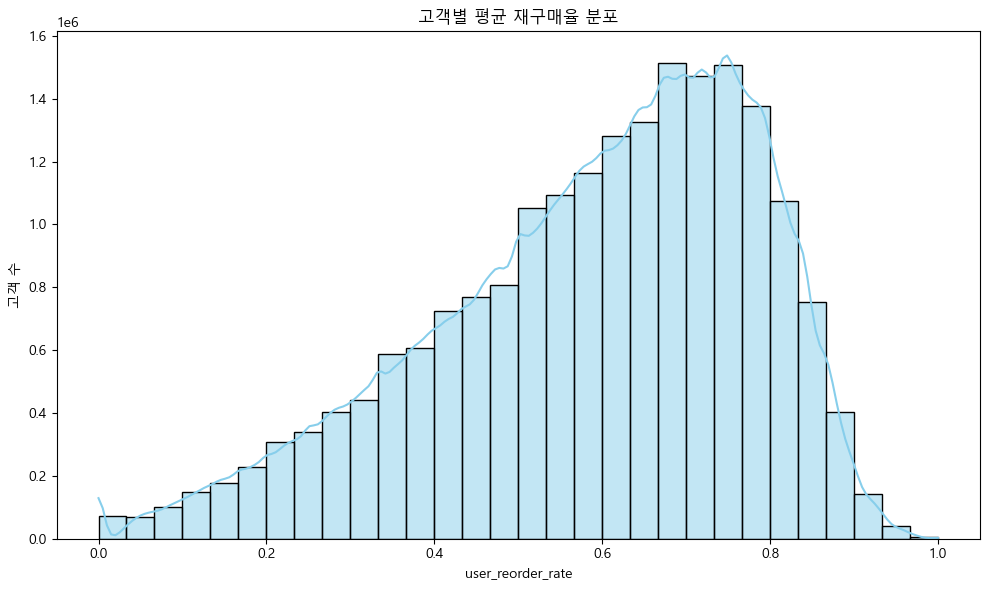

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(df_total['user_reorder_rate'], bins=30, kde=True, color='skyblue')
plt.title('고객별 평균 재구매율 분포')
plt.xlabel('user_reorder_rate')
plt.ylabel('고객 수')
plt.tight_layout()
plt.show()


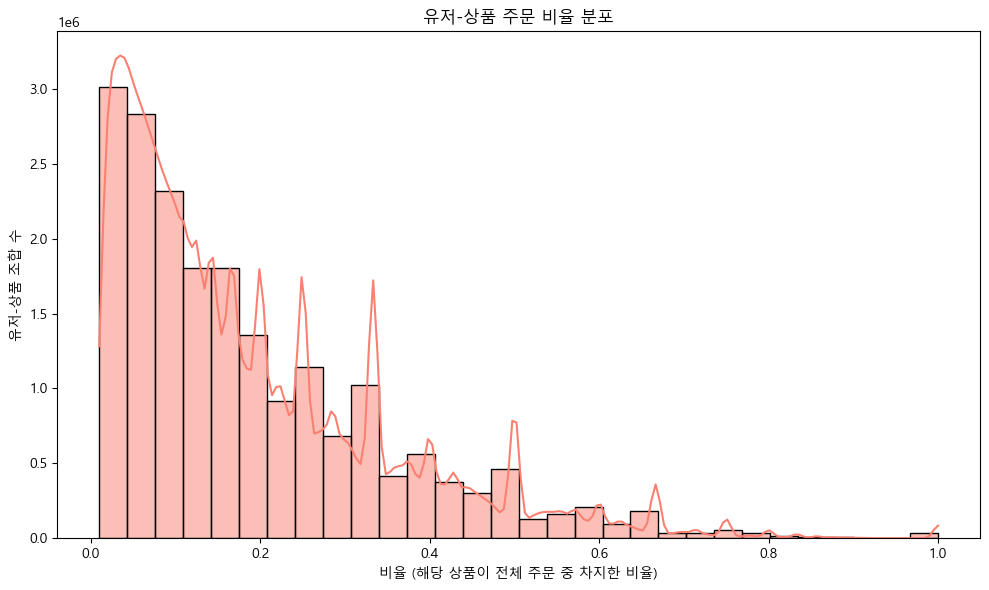

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df_total['user_product_order_ratio'], bins=30, kde=True, color='salmon')
plt.title('유저-상품 주문 비율 분포')
plt.xlabel('비율 (해당 상품이 전체 주문 중 차지한 비율)')
plt.ylabel('유저-상품 조합 수')
plt.tight_layout()
plt.show()


In [30]:
## 머신러닝

In [31]:
df_encoded_clean = df_total.copy()

# 문자열 → 숫자형으로 인코딩
from sklearn.preprocessing import LabelEncoder
categorical_cols = df_encoded_clean.select_dtypes(include='object').columns.tolist()
le = LabelEncoder()

for col in categorical_cols:
    try:
        df_encoded_clean[col] = le.fit_transform(df_encoded_clean[col].astype(str))
    except:
        print(f"Encoding failed for: {col}")

df_encoded_clean = df_encoded_clean.dropna()  # 결측치 제거


In [32]:
from sklearn.model_selection import train_test_split

df_sampled = df_encoded_clean.sample(n=500_000, random_state=42)  # 50만 개 정도만 샘플링

X = df_sampled.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_sampled['reordered']

# Train/Test 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. 모델 생성 및 학습
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 2. 예측
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# 3. 성능 평가 출력
print("📊 [RandomForest] Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 4. 정확도 & AUC 추가 출력
acc = accuracy_score(y_test, y_pred_rf)
auc = roc_auc_score(y_test, y_proba_rf)

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 ROC AUC Score: {auc:.4f}")


📊 [RandomForest] Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     41003
           1       0.97      0.97      0.97     58997

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000

✅ Accuracy: 0.9597
🎯 ROC AUC Score: 0.9948


In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [35]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. 모델 생성 및 학습
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 2. 예측
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# 3. 성능 평가 출력
print("📊 [XGBoost] Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# 4. 정확도 & AUC
acc_xgb = accuracy_score(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"✅ Accuracy: {acc_xgb:.4f}")
print(f"🎯 ROC AUC Score: {auc_xgb:.4f}")


c:\Users\ihdmc\anaconda3\envs\myconda\lib\site-packages\xgboost\core.py:158: UserWarning: [14:04:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 [XGBoost] Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     41003
           1       0.97      0.97      0.97     58997

    accuracy                           0.96    100000
   macro avg       0.96      0.96      0.96    100000
weighted avg       0.96      0.96      0.96    100000

✅ Accuracy: 0.9627
🎯 ROC AUC Score: 0.9954


In [36]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. 모델 생성 및 학습
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=-1,
    min_data_in_leaf=10,
    learning_rate=0.1,
    random_state=42,
    verbose=-1
)
lgb_model.fit(X_train, y_train)

# 2. 예측
y_pred_lgb = lgb_model.predict(X_test)
y_proba_lgb = lgb_model.predict_proba(X_test)[:, 1]

# 3. 성능 평가 출력
print("📊 [LightGBM] Classification Report:")
print(classification_report(y_test, y_pred_lgb))

# 4. 정확도 & AUC
acc_lgb = accuracy_score(y_test, y_pred_lgb)
auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print(f"✅ Accuracy: {acc_lgb:.4f}")
print(f"🎯 ROC AUC Score: {auc_lgb:.4f}")


📊 [LightGBM] Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     41003
           1       0.98      0.97      0.97     58997

    accuracy                           0.97    100000
   macro avg       0.97      0.97      0.97    100000
weighted avg       0.97      0.97      0.97    100000

✅ Accuracy: 0.9680
🎯 ROC AUC Score: 0.9962


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

# 1. 데이터 준비 (샘플링된 데이터 사용 가정)
X = df_sampled.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_sampled['reordered']

# 2. 학습 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. 모델 학습
log_model = LogisticRegression(
    max_iter=1000,  # 반복 수 충분히 늘리기
    solver='lbfgs',  # 기본 solver
    random_state=42
)
log_model.fit(X_train, y_train)

# 4. 예측
y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:, 1]

# 5. 평가
print("📊 [Logistic Regression] Classification Report:")
print(classification_report(y_test, y_pred_log))

acc_log = accuracy_score(y_test, y_pred_log)
auc_log = roc_auc_score(y_test, y_proba_log)

print(f"✅ Accuracy: {acc_log:.4f}")
print(f"🎯 ROC AUC Score: {auc_log:.4f}")


📊 [Logistic Regression] Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87     41003
           1       0.95      0.84      0.90     58997

    accuracy                           0.88    100000
   macro avg       0.88      0.89      0.88    100000
weighted avg       0.89      0.88      0.89    100000

✅ Accuracy: 0.8842
🎯 ROC AUC Score: 0.9553


C:\Users\ihdmc\AppData\Local\Temp\ipykernel_14588\1246641334.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=lgb_feat, y=lgb_feat.index, palette='magma')


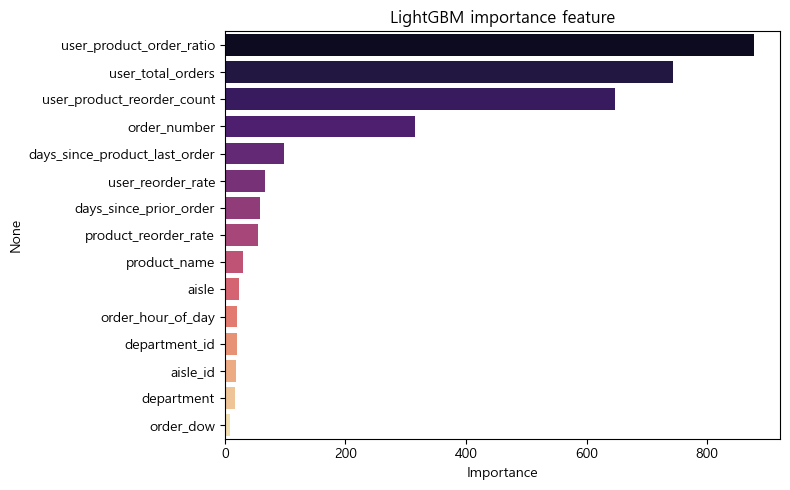

In [38]:

# 6. Feature Importance (LightGBM 기준 시각화)
lgb_feat = pd.Series(lgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
lgb_feat = lgb_feat[lgb_feat.index != 'Unnamed__0']
plt.figure(figsize=(8, 5))
sns.barplot(x=lgb_feat, y=lgb_feat.index, palette='magma')
plt.title('LightGBM importance feature')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

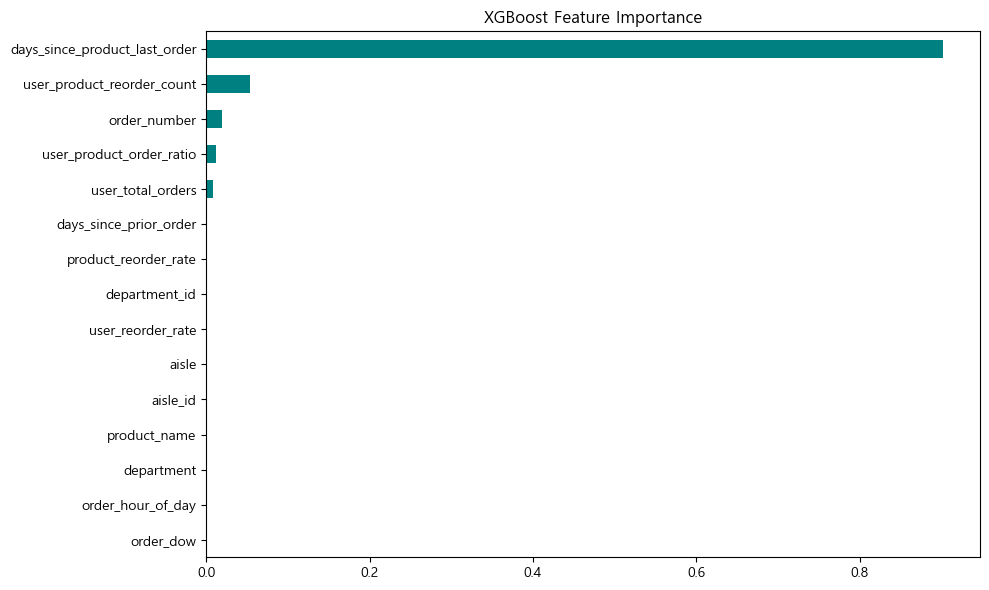

In [39]:
xgb_feat = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
xgb_feat.head(20).plot(kind='barh', color='teal')
plt.title('XGBoost Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pandas as pd

# 1. 데이터 준비: 피처와 타겟 지정
# df_encoded_clean에는 'reordered', 'order_id', 'user_id', 'product_id' 컬럼이 포함되어 있다고 가정
X = df_encoded_clean.drop(columns=['reordered', 'order_id', 'user_id', 'product_id'])
y = df_encoded_clean['reordered']

# 2. 데이터 분할: 70:20:10 (train:validation:test) (Stratified 방식)
# 먼저 90%와 10%로 분리한 후, 90% 중에서 2/9 (약 22.2%)를 validation으로 분리하면,
# 최종적으로 train:validation:test = 70:20:10 이 된다.
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)

# 3. 결과 저장용 딕셔너리 생성
results = {}

# 4. 평가 함수 정의: 모델 학습 후, Validation과 Test 데이터에 대해 classification_report 기준 평가 지표 저장
def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    y_test_pred = model.predict(X_test)
    
    val_report = classification_report(y_val, y_val_pred, output_dict=True)
    test_report = classification_report(y_test, y_test_pred, output_dict=True)
    
    results[name] = {
        'val_precision': round(val_report['weighted avg']['precision'], 2),
        'val_recall': round(val_report['weighted avg']['recall'], 2),
        'val_f1': round(val_report['weighted avg']['f1-score'], 2),
        'val_accuracy': round(val_report['accuracy'], 2),
        'test_precision': round(test_report['weighted avg']['precision'], 2),
        'test_recall': round(test_report['weighted avg']['recall'], 2),
        'test_f1': round(test_report['weighted avg']['f1-score'], 2),
        'test_accuracy': round(test_report['accuracy'], 2)
    }

# 5. 각 모델별 학습 및 평가

# Logistic Regression (클래스 불균형 처리를 위해 class_weight='balanced' 사용)
evaluate_model('Logistic', LogisticRegression(max_iter=100, class_weight='balanced', random_state=42))

# Random Forest (클래스 불균형 처리를 위해 class_weight='balanced' 사용)
evaluate_model('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))

# XGBoost: 학습 시 클래스 불균형 보정을 위해 scale_pos_weight 설정 (양성/음성 비율)
pos_ratio = sum(y_train == 0) / sum(y_train == 1)
evaluate_model('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=pos_ratio))

# LightGBM: is_unbalance=True 옵션으로 불균형 보정
evaluate_model('LightGBM', LGBMClassifier(random_state=42, is_unbalance=True))

# 6. 결과 테이블로 정리하여 출력
df_results = pd.DataFrame(results).T
print("\n📋 모델 성능 비교 (Validation & Test):\n")
print(df_results)


c:\Users\ihdmc\anaconda3\envs\myconda\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
